In [32]:
import SimpleITK as sitk
from PIL import Image

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import os 
import sys
import time
import ast

# Generate labels 

In [3]:
anno_file_path = '/workspace/archive/datasets/lung/LNDb/allNods.csv'
anno_df = pd.read_csv(anno_file_path)
anno_df

,LNDbID,RadID,RadFinding,FindingID,Nodule,x,y,z,DiamEq_Rad,Texture,...,Spiculation,Subtlety,Lobe,TextInstanceID,TextQuestion,Pos_Text,Diam_Text,NodType,Caract_Text,Where
0,1,"1,2,3","1,1,1",1,"1,1,1",-44.203451,-119.073242,-37.5,7.516572,5.0,...,2.333333,3.666667,3,0.0,NaN,apical,8.5,nod,margin: 1,TextReport+RadAnnotation
1,1,1,2,2,1,25.852539,-126.969727,-45.5,6.626905,4.0,...,1.000000,3.000000,1,NaN,NaN,NaN,NaN,NaN,NaN,RadAnnotation
2,2,"1,2,3","1,1,3",1,"1,1,1",88.895508,-123.867513,-129.5,8.971132,5.0,...,1.000000,5.000000,1,0.0,how many?,NaN,NaN,nod,calcification: 5,TextReport+RadAnnotation
3,2,"1,3","2,2",2,"1,1",63.534180,-112.756836,-117.5,6.937737,5.0,...,1.000000,5.000000,1,0.0,how many?,NaN,NaN,nod,calcification: 5,TextReport+RadAnnotation
4,2,"1,3","3,5",3,"1,1",-103.850586,-116.742188,-253.0,8.284458,5.0,...,1.000000,3.500000,5,NaN,NaN,NaN,NaN,NaN,NaN,RadAnnotation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1229,310,5,5,5,0,-21.494141,-84.302734,-35.5,3.000000,NaN,...,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,RadAnnotation
1230,310,5,6,6,0,102.802734,-153.677734,-141.5,3.000000,NaN,...,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,RadAnnotation
1231,311,5,1,1,1,56.570312,-98.507812,-329.4,3.410138,5.0,...,1.000000,3.000000,2,1.0,how many?,NaN,5.0,nod,NaN,TextReport+RadAnnotation
1232,311,NaN,NaN,2,NaN,NaN,NaN,NaN,5.000000,5.0,...,NaN,NaN,[1 2 3 4 5],0.0,how many?,justapleural,5.0,nod,NaN,TextReport (created: texture)


In [4]:
anno_df.drop(columns=['Spiculation', 'Lobe', 'Texture', 'Calcification', 'Caract_Text', 'Sphericity', 'DiamEq_Rad', 'Lobulation', 'Margin', 'Subtlety', 'TextInstanceID', 'TextQuestion', 'Pos_Text', 'Diam_Text', 'x', 'y', 'z', 'InternalStructure'], inplace=True)

In [5]:
print(anno_df)

      LNDbID  RadID RadFinding  FindingID Nodule  Malignancy NodType  \
0          1  1,2,3      1,1,1          1  1,1,1         2.0     nod   
1          1      1          2          2      1         2.0     NaN   
2          2  1,2,3      1,1,3          1  1,1,1         1.0     nod   
3          2    1,3        2,2          2    1,1         1.0     nod   
4          2    1,3        3,5          3    1,1         2.5     NaN   
...      ...    ...        ...        ...    ...         ...     ...   
1229     310      5          5          5      0         NaN     NaN   
1230     310      5          6          6      0         NaN     NaN   
1231     311      5          1          1      1         1.0     nod   
1232     311    NaN        NaN          2    NaN         NaN     nod   
1233     311    NaN        NaN          3    NaN         NaN     nod   

                              Where  
0          TextReport+RadAnnotation  
1                     RadAnnotation  
2          TextReport

In [6]:
anno_df['Malignancy'] = anno_df['Malignancy'].fillna(0)
anno_df['event'] = anno_df.apply(lambda row: 1 if (row['NodType'] == 'nod' and row['Malignancy'] > 3) else 0, axis=1)
anno_df

,LNDbID,RadID,RadFinding,FindingID,Nodule,Malignancy,NodType,Where,event
0,1,"1,2,3","1,1,1",1,"1,1,1",2.0,nod,TextReport+RadAnnotation,0
1,1,1,2,2,1,2.0,NaN,RadAnnotation,0
2,2,"1,2,3","1,1,3",1,"1,1,1",1.0,nod,TextReport+RadAnnotation,0
3,2,"1,3","2,2",2,"1,1",1.0,nod,TextReport+RadAnnotation,0
4,2,"1,3","3,5",3,"1,1",2.5,NaN,RadAnnotation,0
...,...,...,...,...,...,...,...,...,...
1229,310,5,5,5,0,0.0,NaN,RadAnnotation,0
1230,310,5,6,6,0,0.0,NaN,RadAnnotation,0
1231,311,5,1,1,1,1.0,nod,TextReport+RadAnnotation,0
1232,311,NaN,NaN,2,NaN,0.0,nod,TextReport (created: texture),0


In [7]:
event_df = anno_df[anno_df['event'] == 1]
event_df

,LNDbID,RadID,RadFinding,FindingID,Nodule,Malignancy,NodType,Where,event
39,10,2,5,9,1,4.000000,nod,TextReport+RadAnnotation,1
93,24,"1,2","1,1",1,"1,1",3.500000,nod,TextReport+RadAnnotation,1
94,24,"1,2,3","2,2,1",2,"1,1,1",4.666667,nod,TextReport+RadAnnotation,1
208,51,"1,2,3","1,3,1",1,"1,1,1",4.000000,nod,TextReport+RadAnnotation,1
220,55,"1,2,3","1,1,5",1,"1,1,1",3.333333,nod,TextReport+RadAnnotation,1
263,62,"1,2,3","1,1,1",1,"1,0,1",4.000000,nod,TextReport+RadAnnotation,1
273,65,"1,2,3","1,3,2",1,"1,1,1",3.333333,nod,TextReport+RadAnnotation,1
309,73,1,1,1,1,4.000000,nod,TextReport+RadAnnotation,1
310,74,1,1,1,1,4.000000,nod,TextReport+RadAnnotation,1
332,80,1,2,2,1,5.000000,nod,TextReport+RadAnnotation,1


In [8]:
# Base directory where the .mhd and .raw files are stored
base_dir = '/workspace/archive/datasets/lung/LNDb/data'

# Add the 'mdh_path' and 'raw_path' columns
anno_df['mdh_path'] = anno_df['LNDbID'].apply(lambda x: f"{base_dir}/LNDb-{str(x).zfill(4)}.mhd")
anno_df['raw_path'] = anno_df['LNDbID'].apply(lambda x: f"{base_dir}/LNDb-{str(x).zfill(4)}.raw")

# Display the updated DataFrame with the new columns
anno_df[['LNDbID', 'mdh_path', 'raw_path']]

,LNDbID,mdh_path,raw_path
0,1,/workspace/archive/datasets/lung/LNDb/data/LND...,/workspace/archive/datasets/lung/LNDb/data/LND...
1,1,/workspace/archive/datasets/lung/LNDb/data/LND...,/workspace/archive/datasets/lung/LNDb/data/LND...
2,2,/workspace/archive/datasets/lung/LNDb/data/LND...,/workspace/archive/datasets/lung/LNDb/data/LND...
3,2,/workspace/archive/datasets/lung/LNDb/data/LND...,/workspace/archive/datasets/lung/LNDb/data/LND...
4,2,/workspace/archive/datasets/lung/LNDb/data/LND...,/workspace/archive/datasets/lung/LNDb/data/LND...
...,...,...,...
1229,310,/workspace/archive/datasets/lung/LNDb/data/LND...,/workspace/archive/datasets/lung/LNDb/data/LND...
1230,310,/workspace/archive/datasets/lung/LNDb/data/LND...,/workspace/archive/datasets/lung/LNDb/data/LND...
1231,311,/workspace/archive/datasets/lung/LNDb/data/LND...,/workspace/archive/datasets/lung/LNDb/data/LND...
1232,311,/workspace/archive/datasets/lung/LNDb/data/LND...,/workspace/archive/datasets/lung/LNDb/data/LND...


In [9]:
pd.options.display.max_seq_items = 2000
pd.set_option('display.max_colwidth', None)

print(anno_df[['mdh_path']])

                                                      mdh_path
0     /workspace/archive/datasets/lung/LNDb/data/LNDb-0001.mhd
1     /workspace/archive/datasets/lung/LNDb/data/LNDb-0001.mhd
2     /workspace/archive/datasets/lung/LNDb/data/LNDb-0002.mhd
3     /workspace/archive/datasets/lung/LNDb/data/LNDb-0002.mhd
4     /workspace/archive/datasets/lung/LNDb/data/LNDb-0002.mhd
...                                                        ...
1229  /workspace/archive/datasets/lung/LNDb/data/LNDb-0310.mhd
1230  /workspace/archive/datasets/lung/LNDb/data/LNDb-0310.mhd
1231  /workspace/archive/datasets/lung/LNDb/data/LNDb-0311.mhd
1232  /workspace/archive/datasets/lung/LNDb/data/LNDb-0311.mhd
1233  /workspace/archive/datasets/lung/LNDb/data/LNDb-0311.mhd

[1234 rows x 1 columns]


In [10]:
anno_df['Malignancy'] = pd.to_numeric(anno_df['Malignancy'], errors='coerce')

# Group by 'LNDbID' and 'Malignancy' and keep the maximum malignancy for each group
# Using 'drop_duplicates' to keep only one occurrence of the tie if there's a tie
grouped_anno_df = anno_df.loc[anno_df.groupby('LNDbID')['Malignancy'].idxmax()].drop_duplicates(subset=['LNDbID'], keep='first')

grouped_anno_df

,LNDbID,RadID,RadFinding,FindingID,Nodule,Malignancy,NodType,Where,event,mdh_path,raw_path
0,1,"1,2,3","1,1,1",1,"1,1,1",2.0,nod,TextReport+RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0001.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0001.raw
4,2,"1,3","3,5",3,"1,1",2.5,NaN,RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0002.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0002.raw
10,3,"1,3","1,4",1,"1,1",2.0,NaN,RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0003.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0003.raw
17,4,"1,3","3,2",3,"1,1",2.0,NaN,RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0004.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0004.raw
18,5,2,1,1,1,1.0,NaN,RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0005.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0005.raw
...,...,...,...,...,...,...,...,...,...,...,...
1212,307,5,1,1,1,1.0,granu,TextReport+RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0307.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0307.raw
1217,308,5,2,3,1,2.0,NaN,RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0308.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0308.raw
1224,309,NaN,NaN,1,NaN,0.0,micro,TextReport (created: texture),0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0309.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0309.raw
1225,310,"4,5","1,3",1,"0,1",2.0,micro,TextReport+RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0310.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0310.raw


In [11]:
total_event_1 = grouped_anno_df[grouped_anno_df['event'] == 1].shape[0]
print(f"Total number of rows where event is 1: {total_event_1}")

Total number of rows where event is 1: 35


In [12]:
total_event_0 = grouped_anno_df[grouped_anno_df['event'] == 0].shape[0]
print(f"Total number of rows where event is 0: {total_event_0}")

Total number of rows where event is 0: 196


In [74]:
save_csv_file_path = '/workspace/home/tengyuezhang/sybil_cect/data/lndb_labels.csv'
grouped_anno_df.to_csv(save_csv_file_path, index=False)

# Convert mhd and raw to pngs and csv containing slice thickness 

In [13]:
data_root_dir = '/workspace/archive/datasets/lung/LNDb/'
img_dir = os.path.join(data_root_dir, 'data')
test_output_dir = '/workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs'
if not os.path.exists(test_output_dir):
    os.mkdir(test_output_dir)

In [14]:
img_filenames = os.listdir(img_dir)
img_filenames.sort()
img_paths = [os.path.join(img_dir, filename) for filename in img_filenames]
mhd_paths = [path for path in img_paths if path.endswith('.mhd')]
raw_paths = [path for path in img_paths if path.endswith('.raw')]
print(mhd_paths[0:5])
print(raw_paths[0:5])

['/workspace/archive/datasets/lung/LNDb/data/LNDb-0001.mhd', '/workspace/archive/datasets/lung/LNDb/data/LNDb-0002.mhd', '/workspace/archive/datasets/lung/LNDb/data/LNDb-0003.mhd', '/workspace/archive/datasets/lung/LNDb/data/LNDb-0004.mhd', '/workspace/archive/datasets/lung/LNDb/data/LNDb-0005.mhd']
['/workspace/archive/datasets/lung/LNDb/data/LNDb-0001.raw', '/workspace/archive/datasets/lung/LNDb/data/LNDb-0002.raw', '/workspace/archive/datasets/lung/LNDb/data/LNDb-0003.raw', '/workspace/archive/datasets/lung/LNDb/data/LNDb-0004.raw', '/workspace/archive/datasets/lung/LNDb/data/LNDb-0005.raw']


In [87]:
test_mhd_path = mhd_paths[0]
test_raw_path = raw_paths[0]
test_raw_path
test_lndb_id = 'LNDb-0001'

In [79]:
itkimage = sitk.ReadImage(test_mhd_path)
scan = sitk.GetArrayFromImage(itkimage) #3D image
spacing = itkimage.GetSpacing() #voxelsize
origin = itkimage.GetOrigin() #world coordinates of origin
transfmat = itkimage.GetDirection() #3D rotation matrix

In [80]:
scan.shape

(328, 512, 512)

In [81]:
num_slices = scan.shape[0]

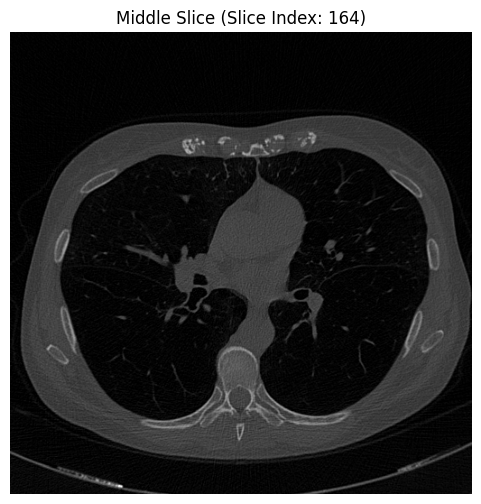

In [84]:
# visualize the middle slice for sanity check 
middle_slice_idx = num_slices // 2
middle_slice = scan[middle_slice_idx, :, :]

# plot 
plt.figure(figsize=(6, 6))
plt.imshow(middle_slice, cmap='gray')
plt.title(f'Middle Slice (Slice Index: {middle_slice_idx})')
plt.axis('off')  # hide axes 
plt.show()

In [92]:


for i in range(num_slices):
    slice_idx = i 
    slice_data = scan[slice_idx, :, :]  # Extract the 2D slice
    
    # Normalize the slice to 8-bit (0-255) for saving as PNG
    slice_min = np.min(slice_data)
    slice_max = np.max(slice_data)
    slice_data = 255.0 * (slice_data - slice_min) / (slice_max - slice_min)
    slice_data = slice_data.astype(np.uint8)
    
    # Convert to PIL Image for saving
    img = Image.fromarray(slice_data)
    
    # Save the image as PNG with the slice index
    case_output_dir = os.path.join(test_output_dir, f'{test_lndb_id}')
    if not os.path.exists(case_output_dir):
        os.mkdir(case_output_dir)
        
    output_path = os.path.join(case_output_dir, f"slice_{i+1:03d}.png")
    img.save(output_path)

    print(f"Saved slice {i+1} to {output_path}")

print("All slices have been saved.")

Saved slice 1 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_001.png
Saved slice 2 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_002.png
Saved slice 3 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_003.png
Saved slice 4 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_004.png
Saved slice 5 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_005.png
Saved slice 6 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_006.png
Saved slice 7 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_007.png
Saved slice 8 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_008.png
Saved slice 9 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_009.png
Saved slice 10 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/sli

Saved slice 91 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_091.png
Saved slice 92 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_092.png
Saved slice 93 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_093.png
Saved slice 94 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_094.png
Saved slice 95 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_095.png
Saved slice 96 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_096.png
Saved slice 97 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_097.png
Saved slice 98 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_098.png
Saved slice 99 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_099.png
Saved slice 100 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LND

Saved slice 177 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_177.png
Saved slice 178 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_178.png
Saved slice 179 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_179.png
Saved slice 180 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_180.png
Saved slice 181 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_181.png
Saved slice 182 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_182.png
Saved slice 183 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_183.png
Saved slice 184 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_184.png
Saved slice 185 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_185.png
Saved slice 186 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb

Saved slice 258 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_258.png
Saved slice 259 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_259.png
Saved slice 260 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_260.png
Saved slice 261 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_261.png
Saved slice 262 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_262.png
Saved slice 263 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_263.png
Saved slice 264 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_264.png
Saved slice 265 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_265.png
Saved slice 266 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb_pngs/LNDb-0001/slice_266.png
Saved slice 267 to /workspace/home/tengyuezhang/sybil_cect/data/test_lndb

# Now, do this to all scans with annotation

In [15]:
data_root_dir = '/workspace/archive/datasets/lung/LNDb/'
img_dir = os.path.join(data_root_dir, 'data')
output_dir = '/workspace/scratch/LNDb_pngs/'
save_csv_file_path = '/workspace/home/tengyuezhang/sybil_cect/data/lndb_labels.csv'

In [16]:
grouped_anno_df

,LNDbID,RadID,RadFinding,FindingID,Nodule,Malignancy,NodType,Where,event,mdh_path,raw_path
0,1,"1,2,3","1,1,1",1,"1,1,1",2.0,nod,TextReport+RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0001.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0001.raw
4,2,"1,3","3,5",3,"1,1",2.5,NaN,RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0002.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0002.raw
10,3,"1,3","1,4",1,"1,1",2.0,NaN,RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0003.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0003.raw
17,4,"1,3","3,2",3,"1,1",2.0,NaN,RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0004.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0004.raw
18,5,2,1,1,1,1.0,NaN,RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0005.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0005.raw
...,...,...,...,...,...,...,...,...,...,...,...
1212,307,5,1,1,1,1.0,granu,TextReport+RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0307.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0307.raw
1217,308,5,2,3,1,2.0,NaN,RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0308.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0308.raw
1224,309,NaN,NaN,1,NaN,0.0,micro,TextReport (created: texture),0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0309.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0309.raw
1225,310,"4,5","1,3",1,"0,1",2.0,micro,TextReport+RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0310.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0310.raw


In [26]:
# cases = grouped_anno_df.head(1)
cases = grouped_anno_df
cases

,LNDbID,RadID,RadFinding,FindingID,Nodule,Malignancy,NodType,Where,event,mdh_path,raw_path
0,1,"1,2,3","1,1,1",1,"1,1,1",2.0,nod,TextReport+RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0001.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0001.raw
4,2,"1,3","3,5",3,"1,1",2.5,NaN,RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0002.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0002.raw
10,3,"1,3","1,4",1,"1,1",2.0,NaN,RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0003.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0003.raw
17,4,"1,3","3,2",3,"1,1",2.0,NaN,RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0004.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0004.raw
18,5,2,1,1,1,1.0,NaN,RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0005.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0005.raw
...,...,...,...,...,...,...,...,...,...,...,...
1212,307,5,1,1,1,1.0,granu,TextReport+RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0307.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0307.raw
1217,308,5,2,3,1,2.0,NaN,RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0308.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0308.raw
1224,309,NaN,NaN,1,NaN,0.0,micro,TextReport (created: texture),0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0309.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0309.raw
1225,310,"4,5","1,3",1,"0,1",2.0,micro,TextReport+RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0310.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0310.raw


In [27]:
voxel_spacings = [] 
png_paths = [] 
for i, row in cases.iterrows():
    LNDbID = row['LNDbID']
    formatted_id_str = f"LNDb-{str(LNDbID).zfill(4)}"
    print(f"Processing {formatted_id_str}")
    
    mhd_path = row['mdh_path'] # TODO: fix this typo 
    
    itkimage = sitk.ReadImage(mhd_path)
    scan = sitk.GetArrayFromImage(itkimage) #3D image
    spacing = itkimage.GetSpacing() #voxelsize
    print(spacing)
    voxel_spacings.append(spacing)
    origin = itkimage.GetOrigin() #world coordinates of origin
    transfmat = itkimage.GetDirection() #3D rotation matrix
    
    num_slices = scan.shape[0]
    
    for i in range(num_slices):
        slice_idx = i 
        slice_data = scan[slice_idx, :, :] 

        # Normalize the slice to 8-bit (0-255) for saving as PNG
        slice_min = np.min(slice_data)
        slice_max = np.max(slice_data)
        slice_data = 255.0 * (slice_data - slice_min) / (slice_max - slice_min)
        slice_data = slice_data.astype(np.uint8)

        # convert to PIL Image
        img = Image.fromarray(slice_data)

        # save the slice as png
        case_output_dir = os.path.join(output_dir, f'{formatted_id_str}')
        if not os.path.exists(case_output_dir):
            os.mkdir(case_output_dir)

        output_path = os.path.join(case_output_dir, f"{i+1:03d}.png")
        img.save(output_path)
    
    png_paths.append(case_output_dir)
    print(f"Case {formatted_id_str} saved to {case_output_dir}")

cases['png_dir'] = png_paths
cases['spacings'] = voxel_spacings

Processing LNDb-0001
(0.607421875, 0.607421875, 1.0)
Case LNDb-0001 saved to /workspace/scratch/LNDb_pngs/LNDb-0001
Processing LNDb-0002
(0.724609375, 0.724609375, 1.0)
Case LNDb-0002 saved to /workspace/scratch/LNDb_pngs/LNDb-0002
Processing LNDb-0003
(0.74609375, 0.74609375, 1.0)
Case LNDb-0003 saved to /workspace/scratch/LNDb_pngs/LNDb-0003
Processing LNDb-0004
(0.712890625, 0.712890625, 1.0)
Case LNDb-0004 saved to /workspace/scratch/LNDb_pngs/LNDb-0004
Processing LNDb-0005
(0.697265625, 0.697265625, 1.0)
Case LNDb-0005 saved to /workspace/scratch/LNDb_pngs/LNDb-0005
Processing LNDb-0007
(0.65234375, 0.65234375, 1.0)
Case LNDb-0007 saved to /workspace/scratch/LNDb_pngs/LNDb-0007
Processing LNDb-0008
(0.65234375, 0.65234375, 1.0)
Case LNDb-0008 saved to /workspace/scratch/LNDb_pngs/LNDb-0008
Processing LNDb-0010
(0.65234375, 0.65234375, 1.0)
Case LNDb-0010 saved to /workspace/scratch/LNDb_pngs/LNDb-0010
Processing LNDb-0011
(0.59375, 0.59375, 1.0)
Case LNDb-0011 saved to /workspace/

/tmp/ipykernel_1137/1458147759.py:27: RuntimeWarning: invalid value encountered in divide
  slice_data = 255.0 * (slice_data - slice_min) / (slice_max - slice_min)
/tmp/ipykernel_1137/1458147759.py:28: RuntimeWarning: invalid value encountered in cast
  slice_data = slice_data.astype(np.uint8)


Case LNDb-0048 saved to /workspace/scratch/LNDb_pngs/LNDb-0048
Processing LNDb-0049
(0.716796875, 0.716796875, 1.0)
Case LNDb-0049 saved to /workspace/scratch/LNDb_pngs/LNDb-0049
Processing LNDb-0050
(0.5234375, 0.5234375, 1.0)
Case LNDb-0050 saved to /workspace/scratch/LNDb_pngs/LNDb-0050
Processing LNDb-0051
(0.65234375, 0.65234375, 1.0)
Case LNDb-0051 saved to /workspace/scratch/LNDb_pngs/LNDb-0051
Processing LNDb-0052
(0.65234375, 0.65234375, 1.0)
Case LNDb-0052 saved to /workspace/scratch/LNDb_pngs/LNDb-0052
Processing LNDb-0053
(0.8828125, 0.8828125, 1.0)
Case LNDb-0053 saved to /workspace/scratch/LNDb_pngs/LNDb-0053
Processing LNDb-0055
(0.73046875, 0.73046875, 1.0)
Case LNDb-0055 saved to /workspace/scratch/LNDb_pngs/LNDb-0055
Processing LNDb-0056
(0.611328125, 0.611328125, 1.0)
Case LNDb-0056 saved to /workspace/scratch/LNDb_pngs/LNDb-0056
Processing LNDb-0059
(0.640625, 0.640625, 1.0)
Case LNDb-0059 saved to /workspace/scratch/LNDb_pngs/LNDb-0059
Processing LNDb-0060
(0.70507

/tmp/ipykernel_1137/1458147759.py:27: RuntimeWarning: overflow encountered in scalar subtract
  slice_data = 255.0 * (slice_data - slice_min) / (slice_max - slice_min)


Case LNDb-0116 saved to /workspace/scratch/LNDb_pngs/LNDb-0116
Processing LNDb-0117
(0.64453125, 0.64453125, 1.0)
Case LNDb-0117 saved to /workspace/scratch/LNDb_pngs/LNDb-0117
Processing LNDb-0118
(0.7109375, 0.7109375, 1.0)
Case LNDb-0118 saved to /workspace/scratch/LNDb_pngs/LNDb-0118
Processing LNDb-0119
(0.5353281497955322, 0.5357324481010437, 1.0)
Case LNDb-0119 saved to /workspace/scratch/LNDb_pngs/LNDb-0119
Processing LNDb-0120
(0.673828125, 0.673828125, 1.0)
Case LNDb-0120 saved to /workspace/scratch/LNDb_pngs/LNDb-0120
Processing LNDb-0121
(0.723883330821991, 0.7244257926940918, 0.9999269973353293)
Case LNDb-0121 saved to /workspace/scratch/LNDb_pngs/LNDb-0121
Processing LNDb-0122
(0.8082031011581421, 0.8082031011581421, 1.0)
Case LNDb-0122 saved to /workspace/scratch/LNDb_pngs/LNDb-0122
Processing LNDb-0123
(0.65234375, 0.65234375, 1.0)
Case LNDb-0123 saved to /workspace/scratch/LNDb_pngs/LNDb-0123
Processing LNDb-0124
(0.7109375, 0.7109375, 1.0)
Case LNDb-0124 saved to /wor

(0.5663594007492065, 0.5663595795631409, 1.0002879585399398)
Case LNDb-0213 saved to /workspace/scratch/LNDb_pngs/LNDb-0213
Processing LNDb-0215
(0.5514531135559082, 0.5514532923698425, 1.0001999800039991)
Case LNDb-0215 saved to /workspace/scratch/LNDb_pngs/LNDb-0215
Processing LNDb-0218
(0.5383398532867432, 0.5383396148681641, 1.0000404991799081)
Case LNDb-0218 saved to /workspace/scratch/LNDb_pngs/LNDb-0218
Processing LNDb-0219
(0.6045390367507935, 0.604539692401886, 1.0001124936725867)
Case LNDb-0219 saved to /workspace/scratch/LNDb_pngs/LNDb-0219
Processing LNDb-0221
(0.5369882583618164, 0.5369880795478821, 0.9996734466815363)
Case LNDb-0221 saved to /workspace/scratch/LNDb_pngs/LNDb-0221
Processing LNDb-0222
(0.4854101538658142, 0.48540979623794556, 1.0001809836224642)
Case LNDb-0222 saved to /workspace/scratch/LNDb_pngs/LNDb-0222
Processing LNDb-0225
(0.4970351457595825, 0.4970345199108124, 1.000312451187128)
Case LNDb-0225 saved to /workspace/scratch/LNDb_pngs/LNDb-0225
Process

(0.612625002861023, 0.6126251816749573, 1.0000499987500624)
Case LNDb-0307 saved to /workspace/scratch/LNDb_pngs/LNDb-0307
Processing LNDb-0308
(0.6640625, 0.6640625, 1.0)
Case LNDb-0308 saved to /workspace/scratch/LNDb_pngs/LNDb-0308
Processing LNDb-0309
(0.5973203182220459, 0.5973201394081116, 1.0005118689950663)
Case LNDb-0309 saved to /workspace/scratch/LNDb_pngs/LNDb-0309
Processing LNDb-0310
(0.72265625, 0.72265625, 1.0)
Case LNDb-0310 saved to /workspace/scratch/LNDb_pngs/LNDb-0310
Processing LNDb-0311
(0.703125, 0.703125, 1.0)
Case LNDb-0311 saved to /workspace/scratch/LNDb_pngs/LNDb-0311


In [28]:
cases

,LNDbID,RadID,RadFinding,FindingID,Nodule,Malignancy,NodType,Where,event,mdh_path,raw_path,png_dir,spacings
0,1,"1,2,3","1,1,1",1,"1,1,1",2.0,nod,TextReport+RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0001.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0001.raw,/workspace/scratch/LNDb_pngs/LNDb-0001,"(0.607421875, 0.607421875, 1.0)"
4,2,"1,3","3,5",3,"1,1",2.5,NaN,RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0002.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0002.raw,/workspace/scratch/LNDb_pngs/LNDb-0002,"(0.724609375, 0.724609375, 1.0)"
10,3,"1,3","1,4",1,"1,1",2.0,NaN,RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0003.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0003.raw,/workspace/scratch/LNDb_pngs/LNDb-0003,"(0.74609375, 0.74609375, 1.0)"
17,4,"1,3","3,2",3,"1,1",2.0,NaN,RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0004.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0004.raw,/workspace/scratch/LNDb_pngs/LNDb-0004,"(0.712890625, 0.712890625, 1.0)"
18,5,2,1,1,1,1.0,NaN,RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0005.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0005.raw,/workspace/scratch/LNDb_pngs/LNDb-0005,"(0.697265625, 0.697265625, 1.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212,307,5,1,1,1,1.0,granu,TextReport+RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0307.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0307.raw,/workspace/scratch/LNDb_pngs/LNDb-0307,"(0.612625002861023, 0.6126251816749573, 1.0000499987500624)"
1217,308,5,2,3,1,2.0,NaN,RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0308.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0308.raw,/workspace/scratch/LNDb_pngs/LNDb-0308,"(0.6640625, 0.6640625, 1.0)"
1224,309,NaN,NaN,1,NaN,0.0,micro,TextReport (created: texture),0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0309.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0309.raw,/workspace/scratch/LNDb_pngs/LNDb-0309,"(0.5973203182220459, 0.5973201394081116, 1.0005118689950663)"
1225,310,"4,5","1,3",1,"0,1",2.0,micro,TextReport+RadAnnotation,0,/workspace/archive/datasets/lung/LNDb/data/LNDb-0310.mhd,/workspace/archive/datasets/lung/LNDb/data/LNDb-0310.raw,/workspace/scratch/LNDb_pngs/LNDb-0310,"(0.72265625, 0.72265625, 1.0)"


In [30]:
cases = cases[['LNDbID', 'Malignancy', 'NodType', 'event', 'spacings', 'png_dir']]
cases

,LNDbID,Malignancy,NodType,event,spacings,png_dir
0,1,2.0,nod,0,"(0.607421875, 0.607421875, 1.0)",/workspace/scratch/LNDb_pngs/LNDb-0001
4,2,2.5,NaN,0,"(0.724609375, 0.724609375, 1.0)",/workspace/scratch/LNDb_pngs/LNDb-0002
10,3,2.0,NaN,0,"(0.74609375, 0.74609375, 1.0)",/workspace/scratch/LNDb_pngs/LNDb-0003
17,4,2.0,NaN,0,"(0.712890625, 0.712890625, 1.0)",/workspace/scratch/LNDb_pngs/LNDb-0004
18,5,1.0,NaN,0,"(0.697265625, 0.697265625, 1.0)",/workspace/scratch/LNDb_pngs/LNDb-0005
...,...,...,...,...,...,...
1212,307,1.0,granu,0,"(0.612625002861023, 0.6126251816749573, 1.0000499987500624)",/workspace/scratch/LNDb_pngs/LNDb-0307
1217,308,2.0,NaN,0,"(0.6640625, 0.6640625, 1.0)",/workspace/scratch/LNDb_pngs/LNDb-0308
1224,309,0.0,micro,0,"(0.5973203182220459, 0.5973201394081116, 1.0005118689950663)",/workspace/scratch/LNDb_pngs/LNDb-0309
1225,310,2.0,micro,0,"(0.72265625, 0.72265625, 1.0)",/workspace/scratch/LNDb_pngs/LNDb-0310


In [31]:
cases.to_csv(save_csv_file_path, index=False)